## Xgboost EsmMean explain

In [1]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from zzd.utils.assess import multi_scores
import matplotlib.pyplot as plt
import sys
import pickle
from sklearn.model_selection import train_test_split
import lime
from lime import lime_tabular


#(1) load features
info_list=['EsmMean']
class Features_C123:
    def __init__(self,info:list):
        class MyFeature():
            def __init__(self,pkl_files, allow_empty=False):
                self.data_loaded = False
                self.data_files = pkl_files
                self.allow_empty = allow_empty #host only feature,
                self.data = None
                self.data_shape = None

            def __getitem__(self,index):
                if not self.data_loaded:
                    self.data = dict()
                    for pkl_file in self.data_files:
                        self.data.update(np.load(pkl_file, allow_pickle=True))
                    self.data_loaded = True
                    self.data_shape = list(self.data.values())[0].shape 
                    if 'average' not in self.data.keys():
                        self.data['average'] = np.array(list(self.data.values())).mean(0)

                if not self.allow_empty:
                    v = self.data[index]
                else:
                    if index in self.data.keys():
                        v = self.data[index] 
                    else:
                        v = self.data['average']
                return v
                
        feature_EsmMean         = MyFeature(["../features/EsmMean/ara_and_eff_only_need_esm2.pkl"])  #shape(1280,)


        self.info = info
        self.features={
            'EsmMean':feature_EsmMean,
            }
    
    def get(self,index,foldn=None):
        #self.features['AraNetProperty'].flag_foldn=foldn
        #self.features['AraNetTarget'].flag_foldn=foldn
        return np.hstack([self.features[i][index] for i in self.info])

    def __getitem__(self,index):
        return np.hstack([self.features[i][index] for i in self.info])
    
features = Features_C123(info=info_list)

    
#(2)set data filenames
c1_train_files = [f'../data/10folds_C1223/C1_train_fold{i}.txt' for i in range(10)] 
c1_test_files  = [f'../data/10folds_C1223/C1_test_fold{i}.txt' for i in range(10)] 
c2_host_unseen_files = [f'../data/10folds_C1223/C2h_fold{i}.txt' for i in range(10)] 
c2_pathogen_unseen_files = [f"../data/10folds_C1223/C2p_fold{i}.txt" for i in range(10)]
c3_files = [f'../data/10folds_C1223/C3_fold{i}.txt' for i in range(10)] 

In [2]:
import matplotlib

#(3) load encode
foldn=0
print(f"fold{foldn}: load file => ",end="\n");sys.stdout.flush();

c1_train           = np.genfromtxt(c1_train_files[foldn],str)
c1_test            = np.genfromtxt(c1_test_files[foldn],str)
c2_host_unseen     = np.genfromtxt(c2_host_unseen_files[foldn],str)
c2_pathogen_unseen = np.genfromtxt(c2_pathogen_unseen_files[foldn],str)
c3                 = np.genfromtxt(c3_files[foldn],str)

print("encode file =>",end="");sys.stdout.flush();#对蛋白进行编码
X_c1_train,           y_c1_train           = c1_train[:,:2],           c1_train[:,2].astype(np.float32)
X_c1_test,            y_c1_test            = c1_test[:,:2],            c1_test[:,2].astype(np.float32)
X_c2_host_unseen,     y_c2_host_unseen     = c2_host_unseen[:,:2],     c2_host_unseen[:,2].astype(np.float32)
X_c2_pathogen_unseen, y_c2_pathogen_unseen = c2_pathogen_unseen[:,:2], c2_pathogen_unseen[:,2].astype(np.float32)
X_c3,                 y_c3                 = c3[:,:2],                 c3[:,2].astype(np.float32)

x_c1_train           = np.array([np.hstack([features.get(j,foldn) for j in i]) for i in X_c1_train ]) 
x_c1_test            = np.array([np.hstack([features.get(j,foldn) for j in i]) for i in X_c1_test ]) 
x_c2_host_unseen     = np.array([np.hstack([features.get(j,foldn) for j in i]) for i in X_c2_host_unseen ]) 
x_c2_pathogen_unseen = np.array([np.hstack([features.get(j,foldn) for j in i]) for i in X_c2_pathogen_unseen ]) 
x_c3                 = np.array([np.hstack([features.get(j,foldn) for j in i]) for i in X_c3 ])
print(" encode done!",end="");

#(4) load model
import pickle
model_file_name = "../output/model_state/C1223_Xgboost_" + "_".join(info_list)+f"_foldn_{foldn}.pkl"
with open(model_file_name,"rb") as f:
    model = pickle.load(f)

fold0: load file => 
encode file => encode done!

In [3]:
from Bio import SeqIO
pos_idx=2
seqs = {i.id: str(i.seq) for i in SeqIO.parse("../data/sequences/only_need.fasta","fasta")}


a,b = X_c1_test[pos_idx]
a_seq,b_seq = seqs[a],seqs[b]


print(f" fold: {foldn}\n protein: {a} {b}\n label:{y_c1_test[pos_idx]}\n pred:",model.predict_proba(x_c1_test[pos_idx:pos_idx+1])[0,1])




 fold: 0
 protein: AT1G69690 CAA48009
 label:1.0
 pred: 0.97236776


In [4]:
x_c1_test[pos_idx:pos_idx+1][0].shape

(5120,)

In [5]:
#calculate the feature importance of each dimension.
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(x_c1_train),    
    feature_names= [str(_) for _ in np.arange(5120)],
    class_names=['neg', 'pos'],
    mode='classification'
)

In [6]:
exp = explainer.explain_instance(
    data_row=x_c1_test[pos_idx],
    predict_fn=model.predict_proba,
    num_features=5120
)

In [7]:
exp_arr = np.empty((5120))
for _ in sorted(exp.as_list()):
    d1,d2 = _ 
    if " < " in d1 and  " <= " in d1:
        exp_arr[int(d1.split(" < ")[1].split(" <= ")[0])] = d2

    elif " > " in d1:
        exp_arr[int(d1.split(" > ")[0])] = d2
       
    elif " <= " in d1:

        exp_arr[int(d1.split(" <= ")[0])] = d2
    else:
        print("error",d1,d2)

# 1. Visualization of the importance of each dimension in the ESM2 feature of Arabidopsis protein and pathogen effector protein

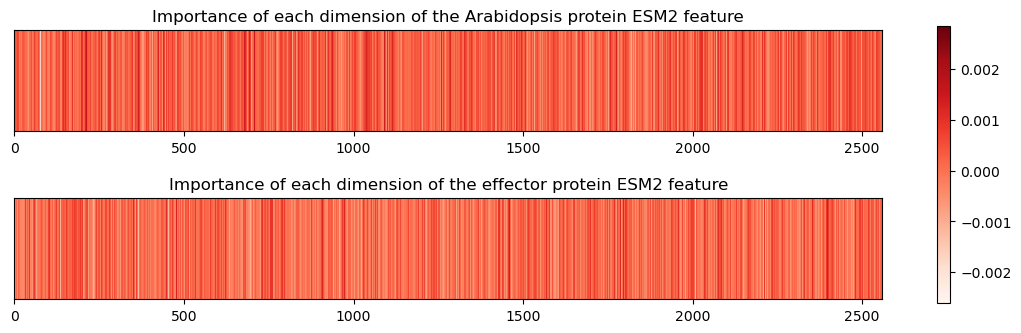

In [18]:


feature_imp = dict()
for k,v in exp.as_list():
    if " < " in k and " <= " in k:
        k = k.split(" < ")[1].split(" <= ")[0]
    elif " > " in k:
        k = k.split(" > ")[0]
    elif " <= " in k:
        k = k.split(" <= ")[0]
    else:
        print("error")
    feature_imp[k]=v

imp_a = np.array([feature_imp[str(_)] for _ in range(5120)])[0:2560]
imp_b = np.array([feature_imp[str(_)] for _ in range(5120)])[2560:]

repeat_num=300
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(14,4))
pcm1 = ax1.imshow(imp_a.repeat(repeat_num).reshape(-1,repeat_num).T,cmap="Reds")
ax1.set_title("Importance of each dimension of the Arabidopsis protein ESM2 feature")
ax1.set_yticks([])
# ax1.set_axis_off()

pcm2 = ax2.imshow(imp_b.repeat(repeat_num).reshape(-1,repeat_num).T,cmap="Reds")
ax2.set_title("Importance of each dimension of the effector protein ESM2 feature")
ax2.set_yticks([])

fig.colorbar(pcm1,ax=[ax1,ax2],shrink=0.9)
plt.savefig("../output/pics/ESM2_features_ablation1.png",dpi =600)


# 2. Mapping the Importance Hist of ESM feature of Arabidopsis and Pathogenic Protein

/home/v/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/v/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


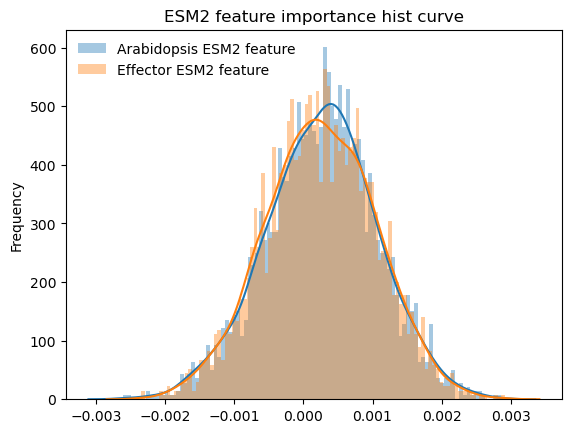

In [29]:
import seaborn as sns
sns.distplot(imp_a, bins=100,kde=True,label="Arabidopsis ESM2 feature")
sns.distplot(imp_b, bins=100,kde=True,label="Effector ESM2 feature")
plt.legend(framealpha=0)
plt.title("ESM2 feature importance hist curve")
plt.ylabel("Frequency")
plt.savefig("../output/pics/ESM2_features_ablation2.png",dpi =600)